In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append("../")

from utils.prep_utils import (
    COLORMAP,
    heatmaps_to_coordinates,
    N_KEYPOINTS,
    RAW_IMG_SIZE,
    MODEL_IMG_SIZE,
    show_batch_predictions,
    DATASET_MEANS,
    DATASET_STDS,
)
from utils.model import ShallowUNet
from utils.dataset import FreiHAND

### Inference Parametes

In [3]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "model_path": "weights/model_final",
    "test_batch_size": 4,
    "device": "cpu",
}

## Data

In [4]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

## Model

In [5]:
model = ShallowUNet(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


## Evaluate on Test Data

In [6]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|██████████| 390/390 [00:24<00:00, 16.20it/s]


In [7]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 4.5% from image size
Average error per keypoint: 6 pixels for image 128x128
Average error per keypoint: 10 pixels for image 224x224


## Inference on Test Data

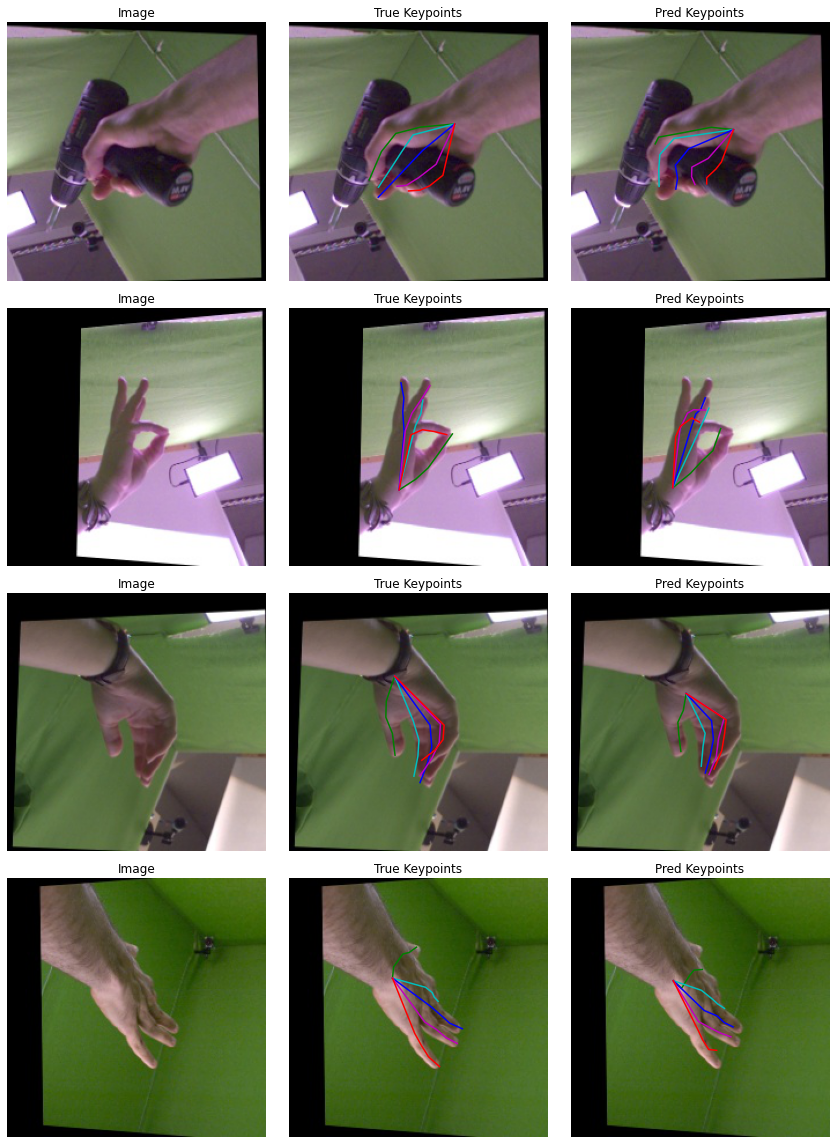

In [8]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break